# PN2V Training
Here we will use the estimated noise model (from the notebooks ```1a_CreateNoiseModel_Calibration.ipynb``` or ```1b_CreateNoiseModel_Bootstrap.ipynb```) and train a PN2V network on single noisy images.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np

from ppn2v.unet import UNet
from ppn2v.pn2v import utils
from ppn2v.pn2v import gaussianMixtureNoiseModel
from ppn2v.pn2v import histNoiseModel
from ppn2v.pn2v import training
from tifffile import imread

# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Load Data

Load the data that needs to be denoised. It is expected that you have downloaded the datasets from https://zenodo.org/record/5156960/files/Mouse%20skull%20nuclei.zip?download=1 and created a noise model (either GMM based or histogram based, using either the notebook ```1a_CreateNoiseModel_GMM.ipynb``` or ```1b_CreateNoiseModel_Histogram.ipynb```). Ensure that for Mouse skull nuclei, the data to be denoised is named ```example2_digital_offset300.tif``` and not the slide edge data. For your dataset, ensure that you load the right data. 

In [2]:
path="../../../data/Mouse skull nuclei/Mouse skull nuclei/"
# Load the training data
data=imread(path+'example2_digital_offset300.tif')
dataName='mouseskullnuclei'

Uncomment the pertinent `nameNoiseModel` to choose the noiseModel of interest

In [3]:
nameNoiseModel ='HistNoiseModel_'+dataName+'_'+'calibration'
#nameNoiseModel='GMMNoiseModel_'+dataName+'_'+str(3)+'_'+str(2)+'_'+'calibration'
#nameNoiseModel ='HistNoiseModel_'+dataName+'_'+'bootstrap'
#nameNoiseModel='GMMNoiseModel_'+dataName+'_'+str(3)+'_'+str(2)+'_'+'bootstrap'


In [4]:
namePN2VModel=nameNoiseModel
if('HistNoiseModel' in namePN2VModel):
    histogram = np.load(path+nameNoiseModel+'.npy') 
    noiseModel= histNoiseModel.NoiseModel(histogram, device=device)
elif('GMMNoiseModel' in namePN2VModel):
    params= np.load(path+nameNoiseModel+'.npz')
    noiseModel = gaussianMixtureNoiseModel.GaussianMixtureNoiseModel(params = params, device = device)
  

### Create the Network and Train it
This can take a while.

In [5]:
# Create a network with 800 output channels that are interpreted as samples from the prior.
net = UNet(800, depth=3)

# Split training and validation data.
my_train_data=data[:-5].copy()
my_val_data=data[-5:].copy()
np.random.shuffle(my_train_data)
np.random.shuffle(my_val_data)

# Start training.
trainHist, valHist = training.trainNetwork(net=net, trainData=my_train_data, valData=my_val_data,
                                           postfix=namePN2VModel, directory=path, noiseModel=noiseModel,
                                           device=device, numOfEpochs= 200, stepsPerEpoch=5, 
                                           virtualBatchSize=20, batchSize=1, learningRate=1e-3)

Epoch 0 finished      
avg. loss: 5.007840847969055+-(2SEM)0.07358239238594598      
Epoch 1 finished      
avg. loss: 4.491580176353454+-(2SEM)0.05775239732785233      
Epoch 2 finished      
avg. loss: 4.332102227210998+-(2SEM)0.037732120350688104      
Epoch 3 finished      
avg. loss: 4.163401007652283+-(2SEM)0.04293894117386502      
Epoch 4 finished      
avg. loss: 4.020141744613648+-(2SEM)0.046695412175806195      
Epoch 5 finished      
avg. loss: 3.96209716796875+-(2SEM)0.03983849356380501      
Epoch 6 finished      
avg. loss: 3.894920802116394+-(2SEM)0.028037882300664226      
Epoch 7 finished      
avg. loss: 3.863226366043091+-(2SEM)0.04562497283892786      
Epoch 8 finished      
avg. loss: 3.775476360321045+-(2SEM)0.03796332401404478      
Epoch 9 finished      
avg. loss: 3.7715038299560546+-(2SEM)0.032123213156894835      
Epoch 10 finished      
avg. loss: 3.762349712848663+-(2SEM)0.04473057709675765      
Epoch 11 finished      
avg. loss: 3.7497058272361756+-(2SEM

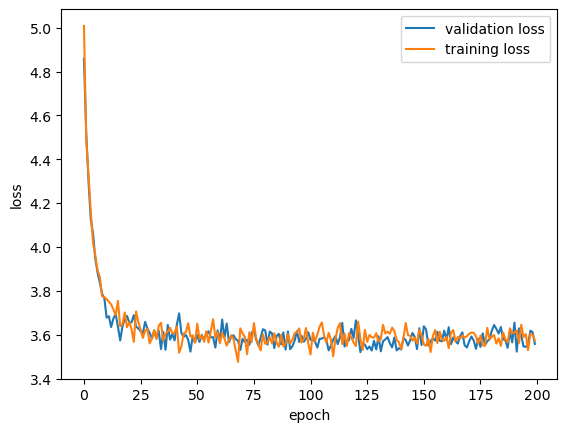

In [6]:
# Let's look at the training and validation loss
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(valHist, label='validation loss')
plt.plot(trainHist, label='training loss')
plt.legend()
plt.show()